# NLP & ML Pipeline Preparation

In this notebook I will develop the code needed to create an NLP and ML pipeline for the project.

### 1. Import libraries and load data from database.

- Import Python libraries
- Load dataset from database 
- Define feature and target variables X and Y

In [2]:
# import libraries
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger'])
nltk.download('stopwords')
import re
import numpy as np
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.utils import resample
import sqlite3
from sqlalchemy import create_engine
import pickle
from sklearn.externals import joblib
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import gensim.models as g
import codecs
%matplotlib inline

[nltk_data] Downloading package punkt to /Users/pranath/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/pranath/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pranath/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pranath/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress


In [3]:
# load data from database
engine = create_engine('sqlite:///DisasterResponse.db')
df = pd.read_sql_table('DisasterResponse', engine)
target_names = ['related', 'request', 'offer', 'aid_related', 'medical_help', 'medical_products', 'search_and_rescue', 'security', 'military', 'water', 'food', 'shelter', 'clothing', 'money', 'missing_people', 'refugees', 'death', 'other_aid', 'infrastructure_related', 'transport', 'buildings', 'electricity', 'tools', 'hospitals', 'shops', 'aid_centers', 'other_infrastructure', 'weather_related', 'floods', 'storm', 'fire', 'earthquake', 'cold', 'other_weather', 'direct_report']
X = df['message']
Y = df[target_names]

In [10]:
# Show 20 example messages
pd.options.display.max_colwidth = 110
for i in range(20):
    print(X.iloc[i])
    print('')

Weather update - a cold front from Cuba that could pass over Haiti

Is the Hurricane over or is it not over

Looking for someone but no name

UN reports Leogane 80-90 destroyed. Only Hospital St. Croix functioning. Needs supplies desperately.

says: west side of Haiti, rest of the country today and tonight

Information about the National Palace-

Storm at sacred heart of jesus

Please, we need tents and water. We are in Silo, Thank you!

I would like to receive the messages, thank you

I am in Croix-des-Bouquets. We have health issues. They ( workers ) are in Santo 15. ( an area in Croix-des-Bouquets )

There's nothing to eat and water, we starving and thirsty.

I am in Petionville. I need more information regarding 4636

I am in Thomassin number 32, in the area named Pyron. I would like to have some water. Thank God we are fine, but we desperately need water. Thanks

Let's do it together, need food in Delma 75, in didine area

More information on the 4636 number in order for me to par

### 2. Write a tokenization function to process text data

In [4]:
def tokenize(text):
    # Remove punctuation characters
    text = re.sub(r"[^a-zA-Z0-9]", " ", text) 
    # Tokenise
    tokens = word_tokenize(text)
    # Create lemmatiser
    lemmatizer = WordNetLemmatizer()

    clean_tokens = []
    # Lemmatize, standardise (lower case) & clean tokens
    for tok in tokens:
        clean_tok = lemmatizer.lemmatize(tok).lower().strip()
        clean_tokens.append(clean_tok)

    # Load stop words
    stop_words = stopwords.words('english')
    # Remove stop words
    clean_tokens = [word for word in clean_tokens if word not in stop_words]
        
    return clean_tokens

### 3. Build a machine learning pipeline

The machine pipeline will take in the `message` column as input and output classification results on the other 36 categories in the dataset. 

In [5]:
# Define ML pipeline
pipeline = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(SVC()))
    ])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [5]:
# Split data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=49)

In [6]:
# Train pipeline
pipeline.fit(X_train, y_train)

# predict on test data
y_pred = pipeline.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred = pd.DataFrame(y_pred)
y_pred.columns = target_names

### 5. Test the model

I will report the f1 score, precision and recall for each output category of the dataset, however I will choose the f1 score to be the key score in determining the best performing model.

In [6]:
def performance_report(actual, predicted, target_names):
    
    metrics = []
    
    # For each of the target features
    for i in target_names:
        # Calculate metrics
        accuracy = accuracy_score(actual[i], predicted[i])
        precision = precision_score(actual[i], predicted[i])
        recall = recall_score(actual[i], predicted[i])
        f1 = f1_score(actual[i], predicted[i])
        # Save metrics
        metrics.append([accuracy, precision, recall, f1])
    
    # Convert to numpy array
    metrics = np.array(metrics)
    # Convert to dataframe
    metrics_df = pd.DataFrame(data = metrics, index = target_names, columns = ['Accuracy', 'Precision', 'Recall', 'F1'])
    # Add mean
    mean_acc = metrics_df['Accuracy'].mean()
    mean_pre = metrics_df['Precision'].mean()
    mean_rec = metrics_df['Recall'].mean()
    mean_f1 = metrics_df['F1'].mean()
    row = pd.Series({'Accuracy':mean_acc,'Precision':mean_pre,'Recall':mean_rec,'F1':mean_f1},name='MEAN SCORE')
    metrics_df = metrics_df.append(row)
    return metrics_df

In [8]:
# Show metrics for each category
print(performance_report(y_test, y_pred, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.763656   0.763656  1.000000  0.865992
request                 0.832926   0.000000  0.000000  0.000000
offer                   0.996338   0.000000  0.000000  0.000000
aid_related             0.587428   0.000000  0.000000  0.000000
medical_help            0.922490   0.000000  0.000000  0.000000
medical_products        0.951938   0.000000  0.000000  0.000000
search_and_rescue       0.973299   0.000000  0.000000  0.000000
security                0.983369   0.000000  0.000000  0.000000
military                0.967043   0.000000  0.000000  0.000000
water                   0.937748   0.000000  0.000000  0.000000
food                    0.891517   0.000000  0.000000  0.000000
shelter                 0.911504   0.000000  0.000000  0.000000
clothing                0.987946   0.000000  0.000000  0.000000
money                   0.977113   0.000000  0.000000  0.000000
missing_people          0.989472   0.000

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


So we can see the metric values vary considerably, this is probably due to the low number of examples for particular categories (as we can see from the warnings, some have no examples to test). In particular while accuracy is high, recall, precison and f1 scores are zero with this model.

### 6. Improve the model

Use grid search to find better parameters. 

In [9]:
#parameters = {
        #'vect__ngram_range': ((1, 2)),
        #'vect__max_df': (0.5, 0.75, 1.0),
        #'vect__max_features': (None, 5000, 10000),
        #'tfidf__use_idf': (True, False),
        #'clf__estimator__n_estimators':[15, 50], 
        #'clf__estimator__min_samples_split':[2, 5, 10]
        #'vect__max_df': (0.5, 0.75),
#}

#cv = GridSearchCV(pipeline, param_grid=parameters)

### 7. Test the model again

Show the accuracy, precision, and recall of the tuned model.  

In [10]:
# Train pipeline with grid search
#cv.fit(X_train, y_train)

# predict on test data
#y_pred2 = cv.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
#y_pred2 = pd.DataFrame(y_pred2)
#y_pred2.columns = target_names

# Evaluate the model
#evaluate_model(y_test, y_pred2, target_names)

### 8. Trying to improve the model further

Reading on various techniques in several articles including these:

https://towardsdatascience.com/machine-learning-multiclass-classification-with-imbalanced-data-set-29f6a177c1a

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/

I decided to try 3 approaches to try to improve results.

- Oversampling minority categories in the data
- Change model to Gradient Boosting 
- Add starting verb feature

#### 8.1 Try a different model

In [72]:
# Logistic regression
# Define ML pipeline
pipeline1 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(LogisticRegression(random_state=1)))
    ])

# Train pipeline
pipeline1.fit(X_train, y_train)

# predict on test data
y_pred1 = pipeline1.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred1 = pd.DataFrame(y_pred1)
y_pred1.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred1, target_names))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                        Accuracy  Precision    Recall        F1
related                 0.821941   0.837496  0.951449  0.890843
request                 0.901282   0.815493  0.528767  0.641551
offer                   0.996338   0.000000  0.000000  0.000000
aid_related             0.781660   0.774472  0.664201  0.715110
medical_help            0.928898   0.664062  0.167323  0.267296
medical_products        0.957125   0.702381  0.187302  0.295739
search_and_rescue       0.974672   0.909091  0.057143  0.107527
security                0.983369   0.000000  0.000000  0.000000
military                0.968874   0.676471  0.106481  0.184000
water                   0.959872   0.805907  0.468137  0.592248
food                    0.942630   0.849687  0.572433  0.684034
shelter                 0.941868   0.813880  0.444828  0.575251
clothing                0.989930   0.882353  0.189873  0.312500
money                   0.978029   0.666667  0.080000  0.142857
missing_people          0.989625   1.000

In [73]:
# Gradient boosting
# Define ML pipeline
pipeline2 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
    ])

# Train pipeline
pipeline2.fit(X_train, y_train)

# predict on test data
y_pred2 = pipeline2.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred2 = pd.DataFrame(y_pred2)
y_pred2.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred2, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.789594   0.794223  0.977822  0.876511
request                 0.900214   0.847244  0.491324  0.621965
offer                   0.993897   0.000000  0.000000  0.000000
aid_related             0.749466   0.780359  0.546598  0.642888
medical_help            0.927983   0.609756  0.196850  0.297619
medical_products        0.960940   0.700680  0.326984  0.445887
search_and_rescue       0.969942   0.387755  0.217143  0.278388
security                0.975282   0.079365  0.045872  0.058140
military                0.970400   0.627907  0.250000  0.357616
water                   0.962313   0.720548  0.644608  0.680466
food                    0.952090   0.789781  0.760900  0.775072
shelter                 0.949344   0.805419  0.563793  0.663286
clothing                0.987946   0.500000  0.569620  0.532544
money                   0.974977   0.400000  0.186667  0.254545
missing_people          0.985810   0.239

So the gradient boosting model seems to perform the best of all models.

#### 8.2 Oversampling minority categories in the data

We saw in the ETL phase how there was a high degree of variance on examples for each of the classes, with some classes/categories having few as 120 examples and others as high as 20,000 examples - so this is a very unbalanced dataset. Two common methods used to address this are oversampling and undersampling. Given our total dataset is around 26,000 rows, I will look at the oversampling technique to generate more samples from the minority category.

In [101]:
# Get the sum of all occurances of all categories
categories_total_train = y_train.sum(axis = 0)
categories_total_train_df = pd.DataFrame(categories_total_train)
categories_total_train_df = categories_total_train_df.sort_values(by=[0])
# List the 10 lowest categories and their total occurances
categories_total_train_df.head(10)

,0
shops,80
offer,94
tools,133
hospitals,216
fire,219
missing_people,229
aid_centers,233
clothing,326
security,362
cold,382


In [102]:
# Get the sum of all occurances of all categories
categories_total_test = y_test.sum(axis = 0)
categories_total_test_df = pd.DataFrame(categories_total_test)
categories_total_test_df = categories_total_test_df.sort_values(by=[0])
# List the 10 lowest categories and their total occurances
categories_total_test_df.head(10)

,0
offer,24
tools,26
shops,40
fire,63
hospitals,67
missing_people,69
aid_centers,76
clothing,79
security,109
electricity,131


In [89]:
# List the 10 highest categories and their total occurances
categories_total_train_df.tail(10)

,0
shelter,1734
storm,1842
earthquake,1886
food,2212
other_aid,2581
request,3379
direct_report,3824
weather_related,5492
aid_related,8156
related,15088


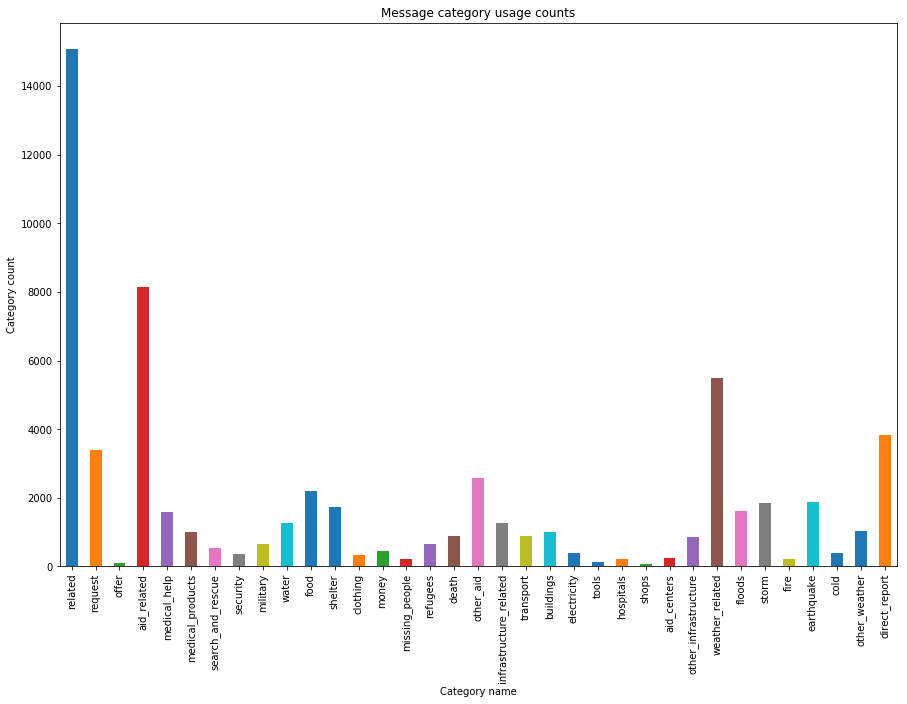

In [7]:
# Create function to show count totals of categories as a bar chart
def plot_target_feature_counts(features_df):
    """"""
    features_totals = features_df.apply(pd.Series.value_counts)
    ax = features_totals.iloc[1].plot.bar(figsize=(15,10))
    ax.set_xlabel("Category name")
    ax.set_ylabel("Category count")
    ax.set_title("Message category usage counts")

plot_target_feature_counts(y_train)

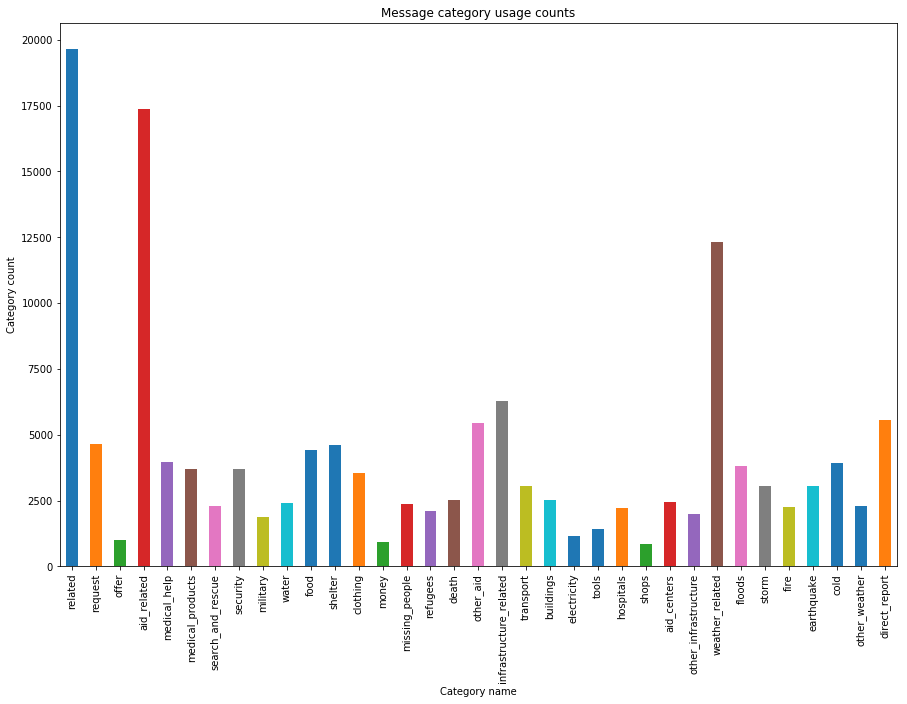

In [104]:
# Rebalance training data to better represent lowest occuring categories
def balance_training_data(training_features, training_targets):
    """"""
    
    # Get features & target names
    training_features = pd.Series.to_frame(training_features)
    feature_names = training_features.columns.values
    target_names = training_targets.columns.values
    # Get counts of training targets
    targets_totals = training_targets.sum(axis = 0)
    # Get mean of training targets
    mean_targets_totals = int(targets_totals.mean())
    # Merge features & targets
    training_df = training_features.join(training_targets)
    # Convert totals to df
    targets_totals = pd.Series.to_frame(targets_totals)
    # Get empty class rows
    empty_rows = training_df.loc[(training_df['related'] == 0)]
    # Get minority class rows 
    minority_rows = training_df.loc[(training_df['shops'] == 1) | (training_df['offer'] == 1) | (training_df['tools'] == 1) | (training_df['hospitals'] == 1) | (training_df['fire'] == 1) | (training_df['missing_people'] == 1) | (training_df['aid_centers'] == 1) | (training_df['clothing'] == 1) | (training_df['security'] == 1) | (training_df['cold'] == 1)]
    minority_rows_balanced = resample(minority_rows, n_samples=training_features.shape[0], random_state=0, replace=True)
    # Merge
    balanced_df = pd.concat([empty_rows, minority_rows_balanced], ignore_index=True)
    # Resplit features from targets
    training_features_balanced = balanced_df[feature_names]
    training_features_balanced = training_features_balanced.T.squeeze()
    training_targets_balanced = balanced_df[target_names]
    # Return balanced features & targets
    return training_features_balanced, training_targets_balanced

    
X_train_bal, y_train_bal = balance_training_data(X_train, y_train)
plot_target_feature_counts(y_train_bal)

We can see how the lowest occuring categories have improved a bit in proportion to the rest, but not by much. Lets try training a model with the more balanced data.

In [15]:
# Train pipeline with balanced data
pipeline2.fit(X_train_bal, y_train_bal)

# predict on test data
y_pred3 = pipeline2.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred3 = pd.DataFrame(y_pred2)
y_pred3.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred3, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.795392   0.801812  0.972428  0.878916
request                 0.903570   0.838946  0.523288  0.644544
offer                   0.992218   0.000000  0.000000  0.000000
aid_related             0.758773   0.804997  0.548077  0.652145
medical_help            0.928746   0.625767  0.200787  0.304024
medical_products        0.961245   0.704698  0.333333  0.452586
search_and_rescue       0.970095   0.387097  0.205714  0.268657
security                0.975435   0.080645  0.045872  0.058480
military                0.968874   0.571429  0.222222  0.320000
water                   0.963381   0.738636  0.637255  0.684211
food                    0.955294   0.800287  0.783404  0.791756
shelter                 0.947971   0.799499  0.550000  0.651685
clothing                0.987641   0.489130  0.569620  0.526316
money                   0.975282   0.409091  0.180000  0.250000
missing_people          0.985352   0.245

But still not much improvement. Lets have a look at the classes and messages associated with samples in the lowest occuring classes.

In [15]:
# Merge features & targets
training_features = pd.Series.to_frame(X_train)
target_names = y_train.columns.values
training_df = training_features.join(y_train)
# Get shop samples
shops_df = training_df.loc[(training_df['shops'] == 1)]
random_10_shops = shops_df.sample(n=10)
# Show 10 random messages for shops category
random_10_shops['message']

40        People from Dal blocked since Wednesday in Carrefour, we having water shortage, food and medical assistance.
18044    A double suicide bombing at a busy marketplace in Borno State's largest city, Maiduguri, on 25 November, w...
12476    calm before the storm heading home after making election calls ready to hunker down hey we are all in this...
21073    The Government has started to demarcate and allocate plots in some areas, but over 230,000 people are stil...
10220    RT gsdog7 RT Huge earthquake hits Haiti Links to specific relief efforts http tinyurl.com yg2hjhu via sami...
14681    Since then, excessive rains have mitigated the anticipated improvements in food security, especially in th...
5926                                           Ruelle Canne-a-Sucre Prolongue (Carrefour) We need tents, water, food. 
22837    We want to reach a stage where robust yam seed production techniques will use parts of the yam plant other...
277                                             

Seems to be difficult to understand from these what these have to do with shops! Lets see the distrbution of other categories in the shop samples.

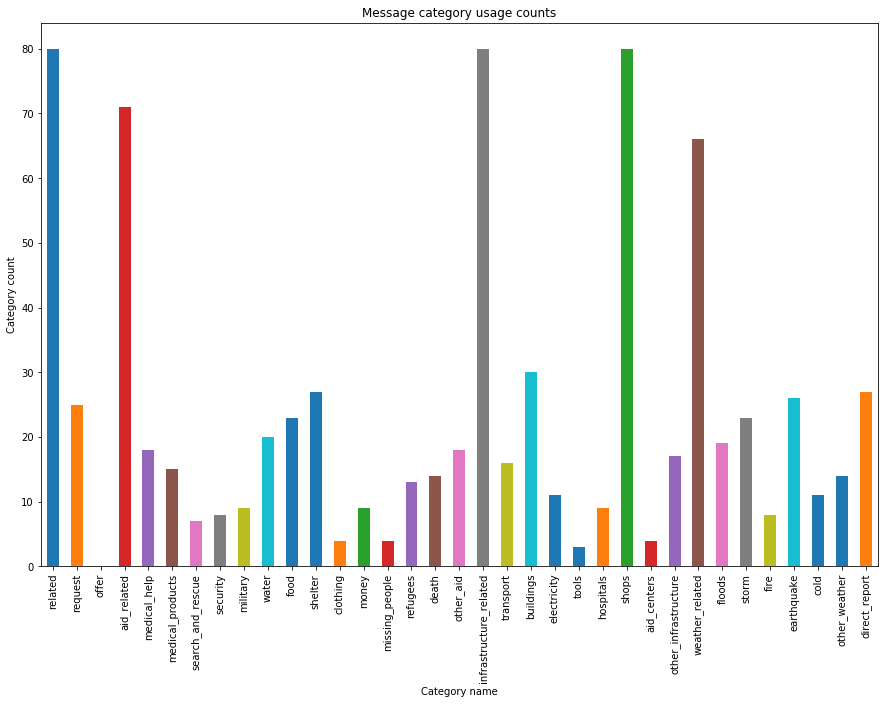

In [16]:
# Plot category counts of all shop category messages
shops_target_classes_df = shops_df[target_names]
plot_target_feature_counts(shops_target_classes_df)

So we can see the samples with all shop categories is still very unbalanced. Lets look at the next lowest category - 'offer'.

In [17]:
# Get shop samples
offer_df = training_df.loc[(training_df['offer'] == 1)]
random_10_offer = offer_df.sample(n=10)
# Show 10 random messages for offer category
random_10_offer['message']

10788                               I can cook and would be happy to try to provide meals or serve in a soup kitchen .
24448                    The medical help involves the setting up of U.S. military mobile surgical hospitals, he said.
11257    I have canned goods , some jars of baby food ( stage 3 ) , children 's books , children 's puzzles , cards...
15353    Initial assessment done have not yet identified the source of the outbreak, but the national task force ha...
11312                                              When and Where should hot meals be delivered this evening ? 11/3/12
10804                                                            I can help packing and distributing food and supplies
20304    They receive free transport from Iran to Herat, where they receive a $10 travel grant, a tarpaulin, blanke...
11221    Looking to donate new ( several-year shelf life , sealed ) non-prescription medications to any organizatio...
11106                                           

Can you tell what might distinguish what an 'offer' is? lets see the category counts for all offer samples.

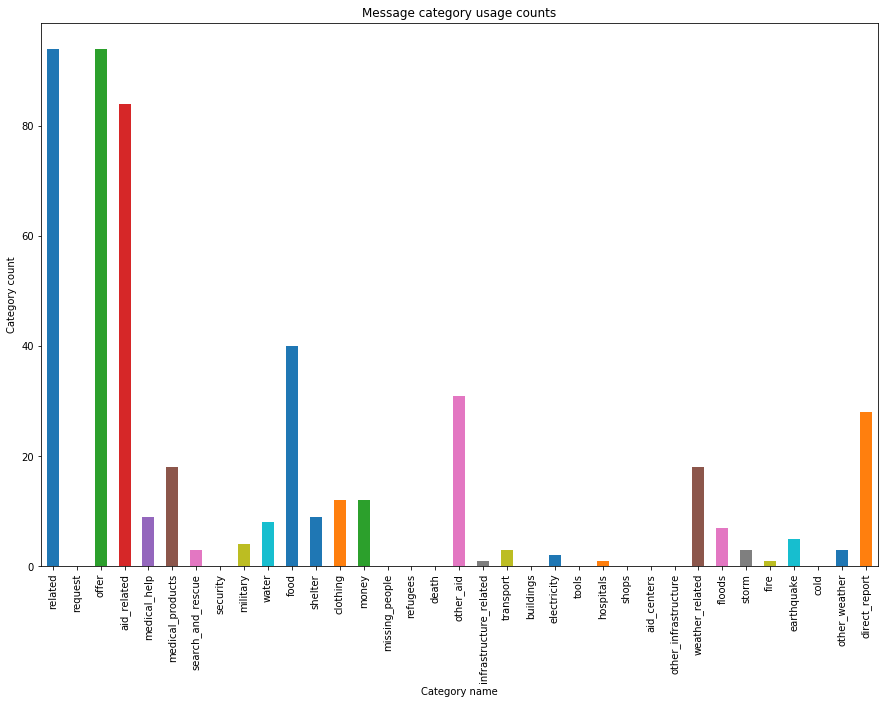

In [18]:
# Plot category counts of all offer category messages
offer_target_classes_df = offer_df[target_names]
plot_target_feature_counts(offer_target_classes_df)

So even if we only use samples from minority classes, we can see how we are still building up an imbalanced dataset that is difficult to train on, let alone the fact that it seems very challenging for any ML model to learn what the categories have in common from the varied and often unclear message data!

#### 8.3 Create new feature for starting verb with new model

In NLP people use a wide range of features to train text classifiers. Some use parts of speech features (such as nouns, verbs etc) as features. With this in mind we will add a new feature that detects any starting verbs.

https://www.nltk.org/book/ch06.html

https://www.analyticsvidhya.com/blog/2018/04/a-comprehensive-guide-to-understand-and-implement-text-classification-in-python/

In [17]:
class StartingVerbExtractor(BaseEstimator, TransformerMixin):

    def starting_verb(self, text):
        sentence_list = nltk.sent_tokenize(text)
        for sentence in sentence_list:
            pos_tags = nltk.pos_tag(tokenize(sentence))
            if pos_tags:
                first_word, first_tag = pos_tags[0]
                #if first_tag in ['VB', 'VBP'] or first_word == 'RT':
                #if first_tag in ['NN', 'NNS', 'NNP', 'NNPS']:
                #    return True
                return False
        return False

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_tagged = pd.Series(X).apply(self.starting_verb)
        return pd.DataFrame(X_tagged)

In [ ]:
# Define new pipeline adding starting verb feature
pipeline3 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('starting_verb', StartingVerbExtractor())
    ])),

    ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
])

# Train pipeline
pipeline3.fit(X_train, y_train)

# predict on test data
y_pred4 = pipeline3.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred4 = pd.DataFrame(y_pred4)
y_pred4.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred4, target_names))

The starting verb feature has not really helped improve the model.

#### 8.4 Combine new model & balanced data & verb feature

In [18]:
# Train pipeline
pipeline3.fit(X_train_bal, y_train_bal)

# predict on test data
y_pred5 = pipeline3.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred5 = pd.DataFrame(y_pred5)
y_pred5.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred5, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.791730   0.828876  0.916484  0.870481
request                 0.885871   0.811490  0.412785  0.547215
offer                   0.990388   0.024390  0.041667  0.030769
aid_related             0.554318   0.479624  0.944527  0.636194
medical_help            0.925694   0.554974  0.208661  0.303290
medical_products        0.957278   0.624113  0.279365  0.385965
search_and_rescue       0.974519   0.571429  0.182857  0.277056
security                0.972994   0.153061  0.137615  0.144928
military                0.969332   0.578947  0.254630  0.353698
water                   0.952548   0.587703  0.796569  0.676379
food                    0.949191   0.781250  0.738397  0.759219
shelter                 0.945377   0.765550  0.551724  0.641283
clothing                0.989777   0.568182  0.632911  0.598802
money                   0.972078   0.305882  0.173333  0.221277
missing_people          0.986268   0.266

A slight improvement with this combination.

#### 8.5 Combine logistic model & balanced data

In [106]:
# Logistic regression
# Define ML pipeline
pipeline5 = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
    ])

# Train pipeline
pipeline5.fit(X_train_bal, y_train_bal)

# predict on test data
y_pred7 = pipeline5.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred7 = pd.DataFrame(y_pred7)
y_pred7.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred7, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.786390   0.809548  0.941858  0.870706
request                 0.883125   0.791150  0.408219  0.538554
offer                   0.989930   0.022727  0.041667  0.029412
aid_related             0.516173   0.459085  0.968935  0.622994
medical_help            0.923558   0.516279  0.218504  0.307054
medical_products        0.956057   0.585987  0.292063  0.389831
search_and_rescue       0.974367   0.581395  0.142857  0.229358
security                0.970552   0.171875  0.201835  0.185654
military                0.968721   0.564706  0.222222  0.318937
water                   0.951175   0.573090  0.845588  0.683168
food                    0.947666   0.772997  0.732771  0.752347
shelter                 0.948276   0.786223  0.570690  0.661339
clothing                0.988862   0.531250  0.645570  0.582857
money                   0.972536   0.352941  0.240000  0.285714
missing_people          0.987489   0.324

Again, not really much improvement with this combination.

#### 8.6 Create new feature for word embedding vector

Word embeddings encourage a vectorisation of words into a feature space where words with a similar meaning occupy a similar part of the feature space. Could these feature help improve performance?

The problem is our low occuring classes have few examples, so simply building a new word embedding model from our text data may not help us generalise so well. I will choose to use pre-trained word embedding models to see if this can help.

##### Glove

Glove is one word embedding model, as described here using a pre-trained model:

https://nlp.stanford.edu/projects/glove/

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/

This model has been trained on 6 billion tokens, and has a vocabulary of 400,000 words - and creates 300 dimension feature vectors from text.

Lets try pre-trained Glove word embeddings.

In [33]:
with open("glove.6B/glove.6B.300d.txt", "rb") as lines:
    w2v = {line.split()[0]: np.array(map(float, line.split()[1:]))
           for line in lines}

In [34]:
# Define vectorisers for glove word embeddings
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        #self.dim = len(word2vec.itervalues().next())
        self.dim = 300

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        #self.dim = len(word2vec.itervalues().next())
        #self.dim = len(next(iter(word2vec.values())))
        self.dim = 300

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])
    

In [86]:
# Logistic regression
# Define ML pipeline

pipeline4 = Pipeline([
    ('features', FeatureUnion([

        ('text_pipeline', Pipeline([
            ('vect', CountVectorizer(tokenizer=tokenize)),
            ('tfidf', TfidfTransformer())
        ])),

        ('word2vec_vectorizer', MeanEmbeddingVectorizer(w2v))
    ])),

    ('clf', MultiOutputClassifier(LogisticRegression(random_state=1)))
])



# Train pipeline
pipeline4.fit(X_train, y_train)

# predict on test data
y_pred6 = pipeline4.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred6 = pd.DataFrame(y_pred6)
y_pred6.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred6, target_names))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


                        Accuracy  Precision    Recall        F1
related                 0.821941   0.837496  0.951449  0.890843
request                 0.901282   0.815493  0.528767  0.641551
offer                   0.996338   0.000000  0.000000  0.000000
aid_related             0.781660   0.774472  0.664201  0.715110
medical_help            0.928898   0.664062  0.167323  0.267296
medical_products        0.957125   0.702381  0.187302  0.295739
search_and_rescue       0.974672   0.909091  0.057143  0.107527
security                0.983369   0.000000  0.000000  0.000000
military                0.968874   0.676471  0.106481  0.184000
water                   0.959872   0.805907  0.468137  0.592248
food                    0.942630   0.849687  0.572433  0.684034
shelter                 0.941868   0.813880  0.444828  0.575251
clothing                0.989930   0.882353  0.189873  0.312500
money                   0.978029   0.666667  0.080000  0.142857
missing_people          0.989625   1.000

So the glove pre-trained embedding feature vectoriser has not helped improve performance.

##### Doc2vec

Lets look at Doc2Vec pre-trained word embedding models, as described here:

http://ai.intelligentonlinetools.com/ml/text-clustering-doc2vec-word-embedding-machine-learning/

https://github.com/jhlau/doc2vec

https://markroxor.github.io/gensim/static/notebooks/doc2vec-wikipedia.html

https://arxiv.org/pdf/1507.07998.pdf

We will used a pre-trained model trained on 4.5 million wikipedia articles, and has a vocabulary of just under 1 million words, that also generates 300 dimension feature vectors.

Note: default doc2vec from genism library does not facilitate pre-trained models, to download a forked version that can install genism fresh via 'pip install -U gensim'.

In [9]:
# Load pre-trained model from file 
model="doc2vec/doc2vec.bin"
 
#inference hyper-parameters
start_alpha=0.01
infer_epoch=1000

# Load pre-trained model
doc2vec = g.Doc2Vec.load(model)

# Lets show an example 300 feature vector for the first message of our training set
document = tokenize(X_train[0])
vector = doc2vec.infer_vector(document, alpha=start_alpha, steps=infer_epoch)
print((vector))

[ 1.05389304e-01  1.87241346e-01 -1.00067124e-01 -5.84028900e-01
  1.07543826e-01 -1.25103831e-01  5.27499676e-01 -3.75652641e-01
  1.17975600e-01 -2.81796735e-02 -2.52026796e-01 -5.09442866e-01
 -3.21979113e-02  5.03063910e-02 -9.26744118e-02  7.11919814e-02
 -3.74514908e-01 -1.73789307e-01 -4.19825137e-01 -1.91427618e-01
 -3.20386916e-01 -1.20774277e-01  6.60605073e-01 -2.06124559e-01
  2.82651335e-01 -1.03867702e-01 -3.02995201e-02  2.58385479e-01
  2.15882078e-01 -3.05927601e-02 -1.70235932e-01  2.70004213e-01
 -1.28700301e-01  4.80530083e-01  4.43913430e-01 -3.66875350e-01
  2.82368422e-01  8.34432766e-02  2.97592998e-01  2.10374564e-01
 -4.34435606e-01 -2.89152443e-01  1.74317762e-01 -5.44270277e-01
 -2.76181340e-01  1.26449972e-01  1.77189916e-01  3.56412947e-01
 -7.53176287e-02 -7.59698525e-02 -5.08393534e-03 -1.90379962e-01
 -2.81680245e-02 -2.49372572e-01 -3.11455935e-01 -4.48736221e-01
 -9.68318954e-02 -1.48736425e-02 -1.02294259e-01 -7.75747327e-03
 -3.89026962e-02 -3.53648

In [10]:
# Create a transformer class for our pipeline that uses the pre-trained doc2vec model
# Logistic regression
class Doc2vecVectorizer(object):
    def __init__(self, doc2vec):
        self.doc2vec = doc2vec

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.asmatrix(np.array([self.doc2vec.infer_vector(tokenize(document)) for document in X]))

    
    
# Define new pipeline
pipeline6 = Pipeline([
        ('doc2vec_vectorizer', Doc2vecVectorizer(doc2vec)),
        ('clf', MultiOutputClassifier(LogisticRegression(random_state=1)))
    ])

# Train pipeline
pipeline6.fit(X_train, y_train)

# predict on test data
y_pred7 = pipeline6.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred7 = pd.DataFrame(y_pred7)
y_pred7.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred7, target_names))

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  Futur

                        Accuracy  Precision    Recall        F1
related                 0.824382   0.856984  0.924276  0.889359
request                 0.887702   0.773212  0.463927  0.579909
offer                   0.996338   0.000000  0.000000  0.000000
aid_related             0.767013   0.755315  0.643861  0.695149
medical_help            0.928898   0.600962  0.246063  0.349162
medical_products        0.956057   0.613445  0.231746  0.336406
search_and_rescue       0.974367   0.684211  0.074286  0.134021
security                0.982911   0.200000  0.009174  0.017544
military                0.972383   0.633588  0.384259  0.478386
water                   0.950870   0.691964  0.379902  0.490506
food                    0.935459   0.749135  0.609001  0.671839
shelter                 0.942478   0.773585  0.494828  0.603575
clothing                0.990235   0.674419  0.367089  0.475410
money                   0.978334   0.564516  0.233333  0.330189
missing_people          0.989319   0.333

In [11]:
# Define new pipeline
# Gradient boosting
pipeline7 = Pipeline([
        ('doc2vec_vectorizer', Doc2vecVectorizer(doc2vec)),
        ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
    ])

# Train pipeline
pipeline7.fit(X_train, y_train)

# predict on test data
y_pred8 = pipeline7.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred8 = pd.DataFrame(y_pred8)
y_pred8.columns = target_names

# Evaluate the model
print(performance_report(y_test, y_pred8, target_names))

                        Accuracy  Precision    Recall        F1
related                 0.826060   0.847509  0.941658  0.892107
request                 0.884956   0.787521  0.426484  0.553318
offer                   0.992524   0.000000  0.000000  0.000000
aid_related             0.756485   0.738587  0.634246  0.682451
medical_help            0.931492   0.680982  0.218504  0.330849
medical_products        0.953158   0.540000  0.171429  0.260241
search_and_rescue       0.970857   0.192308  0.028571  0.049751
security                0.977571   0.047619  0.018349  0.026490
military                0.970095   0.590909  0.300926  0.398773
water                   0.942936   0.639344  0.191176  0.294340
food                    0.917608   0.713217  0.402250  0.514388
shelter                 0.934239   0.792157  0.348276  0.483832
clothing                0.986421   0.391304  0.227848  0.288000
money                   0.975587   0.407407  0.146667  0.215686
missing_people          0.982911   0.042

### 9. Summary of best improvements

So the model with the best f1 score was the gradient boosting model, with balanced data & starting verb feature - which gives us a mean F1 score of 0.407.

We also know that while this is the mean, there is high variance in the results for each category - some target categories have very good scores, while others have very poor scores. The possible reasons for this highlighted earlier include:

- Some categories have very few examples (around 100)
- The content of the messages for many of these low value categories seem particularly difficult to correlate (to humans anyway!)

Therefore, with such variable results it is difficult to see how we could deploy even this best model. However, if we use a 'triage' approach from medicine - if we only trained a model on those categories that have an F1 score of more than 0.5, while it could not be used to predict certain categories, those that it did it could do so more reliably - making the whole model more reliable.

For our best model, the categories (excluding the questionable 'related' category) that have a F1 score of at least 0.5 are:

- earthquake - 0.790918
- food - 0.759219
- weather_related - 0.712544
- water - 0.676379
- floods - 0.659142
- shelter - 0.641283
- aid_related - 0.636194
- storm - 0.613615
- clothing - 0.598802
- cold - 0.587156
- request - 0.547215
- death - 0.540881
- direct_report - 0.505040

We will therefore re-train our best model, to target only these categories and will then run a grid search on these in our command line application.

In [ ]:
# Subset data to predict only top performing categories
target_names_best = ['aid_related', 'water', 'food', 'shelter', 'clothing', 'death', 'weather_related', 'floods', 'storm', 'earthquake', 'cold', 'request', 'direct_report']
Y_best = df[target_names_best]
# Split data into train and test
X_train, X_test, Y_train_best, Y_test_best = train_test_split(X, Y_best, random_state=49)

# Run best model on data
pipeline_best = Pipeline([
        ('vect', CountVectorizer(tokenizer=tokenize)),
        ('tfidf', TfidfTransformer()),
        ('clf', MultiOutputClassifier(GradientBoostingClassifier(random_state=1)))
    ])

# Train pipeline
pipeline_best.fit(X_train, Y_train_best)

# predict on test data
y_pred8 = pipeline_best.predict(X_test)

# Re-structure returned numpy array as dataframe with same column names
y_pred8 = pd.DataFrame(y_pred8)
y_pred8.columns = target_names_best

# Evaluate the model
print(performance_report(y_test, y_pred8, target_names_best))

In [ ]:
print(pipeline_best.steps)

This model now has a mean F1 score of XX for the top 13 target categories.

### 10. Export the model and subset data

In [19]:
# save the model as pickle file to disk
filename = 'final_model.sav'
joblib.dump(pipeline_best, 'final_model.sav')

['final_model.sav']

In [ ]:
# Merge optimised features & targets
features_opt = pd.Series.to_frame(X)
training__opt_df = features_opt.join(Y_best)
# Delete previous db
os.remove("DisasterResponseOpt.db")
# Save current version of database
engine = db.create_engine('sqlite:///DisasterMessagesOpt.db')
training__opt_df.to_sql('DisasterMessagesOpt', engine, index=False)